In [ ]:
# import sys
# !{sys.executable} -m pip install nltk 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import json 
import datetime
import time
from PIL import Image
from wordcloud import WordCloud

plt.rc("axes.spines", top=False, right=False)
sns.set_context("poster")
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [ ]:
def get_status_text(df_row):
    #retweet
    if isinstance(df_row.retweeted_status, dict):
        text = df_row.retweeted_status['full_text']
    #quote
    elif isinstance(df_row.quoted_status, dict):
        text = df_row.quoted_status["full_text"]
    # regular tweet
    else:
        text = df_row['full_text']
    return text

In [ ]:
import flair
from flair.data import Sentence
from flair.models import TextClassifier

# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sian = SentimentIntensityAnalyzer()
from textblob import TextBlob


In [ ]:
# use different pretrained models
text = "This is so bad."

classifier = TextClassifier.load('sentiment')
sentence = Sentence(text)

classifier.predict(sentences=sentence)
result = sentence.labels
for label in result:
    value = label.value
    score = label.score
    print (value, score)
compound = sian.polarity_scores(text)["compound"]
print ("nltk vader: {}".format(compound))
txtblob = TextBlob(text).sentiment[0]
print ("textblob: {}".format(txtblob))

In [ ]:
# load tweets
path = r"U:\Data_Analysis\pak6\DS project\ar-vr_tweets.pkl"
df_tweets = pd.read_pickle(path)
df_tweets.head()

In [ ]:
df_tweets.columns

In [ ]:
df_tweets.retweet_count.describe()

In [ ]:
sns.displot(np.log10(df_tweets.retweet_count+1), kde= True)
plt.savefig("dist_retweets.png")

In [ ]:
import re

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'\n',
    r"^\s+|\s+$"
]
cleaner_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
def process_tweet(tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
#         return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) \
#                                     |(\w+:\/\/\S+)", " ", tweet).split())
    
        return cleaner_re.sub("", tweet)

In [ ]:
text = "@abd here is the text https://ascagf123 "
process_tweet(text)

In [ ]:
def sentim_flair(sentence):
    classifier.predict(sentences=sentence)
    result = sentence.labels
    if result[0].value.startswith("N"):
        return -1*round(result[0].score, 5)
    else:
        return round(result[0].score, 5)

In [ ]:
# select relevant info
df_tweets_2 = df_tweets[["created_at", "id", "retweet_count", "favorite_count"]]
df_tweets_2.loc[:, "followers_count"] = df_tweets["user"].apply(lambda x: x["followers_count"])
df_tweets_2.loc[:, "friends_count"] = df_tweets["user"].apply(lambda x: x["friends_count"])
df_tweets_2.loc[:, "text"] = df_tweets.apply(get_status_text, axis = 1)
df_tweets_2.head()

In [126]:
df_tweets_2.head()

,created_at,id,retweet_count,favorite_count,followers_count,friends_count,text,flair,txtblob,vader
0,2020-09-11 02:42:28,1304248919329775617,4,0,670,684,Hololens will make new imagination\nvia @gigad...,0.99801,0.13636,0.0000
1,2020-09-11 02:42:06,1304248824089567232,49,0,472,338,(1/18) 📢Need videos for #teaching about #fores...,-0.78461,-0.15625,0.5449
2,2020-09-11 02:42:03,1304248812450521088,1,0,4613,1,A systematic review of immersive virtual reali...,0.99847,0.12500,0.0000
3,2020-09-11 02:41:02,1304248557642412033,0,0,116151,82001,"Holopoint Oculus Quest Review: Brilliant, Dizz...",0.99984,0.90000,0.5859
4,2020-09-11 02:38:09,1304247833545994241,0,0,109,509,Talking about some of the work I've done over ...,0.99924,0.20000,0.4404


In [ ]:
# perform sentiment analysis
data = df_tweets_2.drop_duplicates(subset = ["id", "text"]).reset_index(drop = True)
d_flair = {}
d_txtblob = {}
d_vader = {}
for idx in data.index[:]:
    text = data.iloc[idx].text
    cleaned_text = process_tweet(text)
    tweet_id = data.iloc[idx].id 
    
    try:
#     print (text)
#     print (cleaned_text)
#     classifier = TextClassifier.load('sentiment')
        sentence = Sentence(cleaned_text)
        score = sentim_flair(sentence)
        d_flair[tweet_id] = score

        compound = sian.polarity_scores(cleaned_text)["compound"]
        d_vader[tweet_id] = round(compound, 5)

        txtblob = TextBlob(cleaned_text).sentiment[0]
        d_txtblob[tweet_id] = round(txtblob, 5)
    
    except Exception as e: 
        print (str(e))

    
#     print ("flair: {}".format(score))
#     print ("nltk vader: {}".format(compound))
#     print ("textblob: {}".format(txtblob))
#     print ("-------")

In [127]:
len(d_flair)

10831

In [ ]:
df_tweets_2.loc[:, "flair"] = df_tweets_2["id"].map(d_flair)
df_tweets_2.loc[:, "txtblob"] = df_tweets_2["id"].map(d_txtblob)
df_tweets_2.loc[:, "vader"] = df_tweets_2["id"].map(d_vader)
df_tweets_2.head()

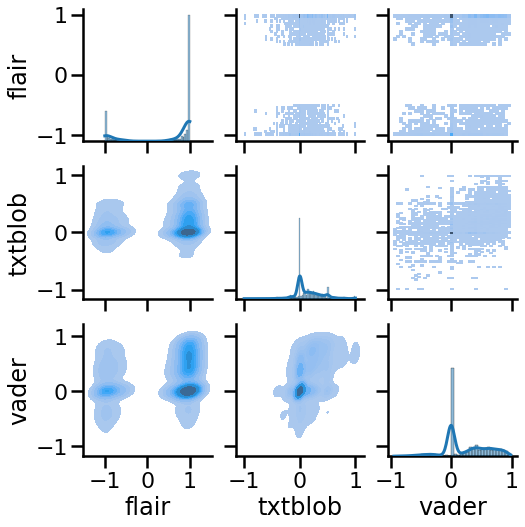

In [129]:
g = sns.PairGrid(df_tweets_2[["flair", "txtblob", "vader"]])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)
# plt.savefig("method_comparison.png")

In [128]:
df_tweets_2.head()

,created_at,id,retweet_count,favorite_count,followers_count,friends_count,text,flair,txtblob,vader
0,2020-09-11 02:42:28,1304248919329775617,4,0,670,684,Hololens will make new imagination\nvia @gigad...,0.99801,0.13636,0.0000
1,2020-09-11 02:42:06,1304248824089567232,49,0,472,338,(1/18) 📢Need videos for #teaching about #fores...,-0.78461,-0.15625,0.5449
2,2020-09-11 02:42:03,1304248812450521088,1,0,4613,1,A systematic review of immersive virtual reali...,0.99847,0.12500,0.0000
3,2020-09-11 02:41:02,1304248557642412033,0,0,116151,82001,"Holopoint Oculus Quest Review: Brilliant, Dizz...",0.99984,0.90000,0.5859
4,2020-09-11 02:38:09,1304247833545994241,0,0,109,509,Talking about some of the work I've done over ...,0.99924,0.20000,0.4404


In [133]:
df_tweets_2.dtypes

created_at         datetime64[ns]
id                          int64
retweet_count               int64
favorite_count              int64
followers_count             int64
friends_count               int64
text                       object
flair                     float64
txtblob                   float64
vader                     float64
dtype: object

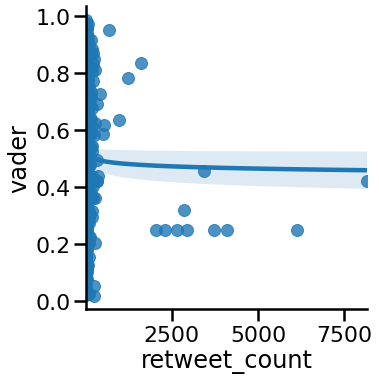

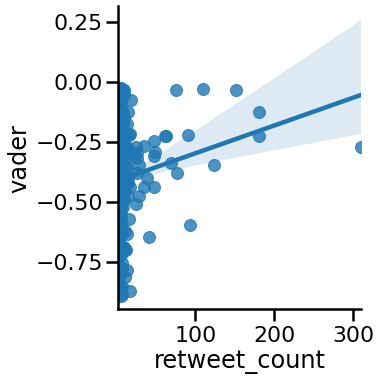

In [143]:
data = df_tweets_2[(df_tweets_2.retweet_count > 1)]
model = "vader"
x = "retweet_count"
sns.lmplot(x = x, y = model, data = data[data[model] > 0], logx = True)
sns.lmplot(x = x, y = model, data = data[data[model] < 0])

In [237]:
models= ["flair", "vader", "txtblob"]
x = "retweet_count"
bins = [0, 50, 100, 500, 1000, 1e4]
df_tweets_2[x + "_cut"] = pd.cut(df_tweets_2[x], bins = bins,  labels= bins[:-1]) 
# df_tweets_2[x + "_qcut"] = pd.qcut(df_tweets_2[x], q=5,  labels=np.arange(5)) 
df_tweets_2.head()

,created_at,id,retweet_count,favorite_count,followers_count,friends_count,text,flair,txtblob,vader,retweet_countcut,retweet_count_cut,retweet_count_qcut,followers_count_cut,favorite_count_cut,flair_cut
0,2020-09-11 02:42:28,1304248919329775617,4,0,670,684,Hololens will make new imagination\nvia @gigad...,0.99801,0.13636,0.0000,0,0,0,500,NaN,POS
1,2020-09-11 02:42:06,1304248824089567232,49,0,472,338,(1/18) 📢Need videos for #teaching about #fores...,-0.78461,-0.15625,0.5449,0,0,0,100,NaN,NEG
2,2020-09-11 02:42:03,1304248812450521088,1,0,4613,1,A systematic review of immersive virtual reali...,0.99847,0.12500,0.0000,0,0,0,1000,NaN,POS
3,2020-09-11 02:41:02,1304248557642412033,0,0,116151,82001,"Holopoint Oculus Quest Review: Brilliant, Dizz...",0.99984,0.90000,0.5859,0,NaN,0,1000,NaN,POS
4,2020-09-11 02:38:09,1304247833545994241,0,0,109,509,Talking about some of the work I've done over ...,0.99924,0.20000,0.4404,0,NaN,0,100,NaN,POS


In [232]:
df_tweets_2[x+"_cut"].describe()

count     10835
unique        5
top          -1
freq      10619
Name: retweet_count_cut, dtype: int64

In [179]:
qcut_series, cut_intervals = pd.cut(df_tweets_2[x], bins = bins,  labels=np.arange(5), retbins=True) 
print (cut_intervals)
qcut_series.value_counts()

[0.e+00 5.e+01 1.e+02 5.e+02 1.e+03 2.e+07]


0    5187
1     104
2      89
4      15
3       8
Name: retweet_count, dtype: int64

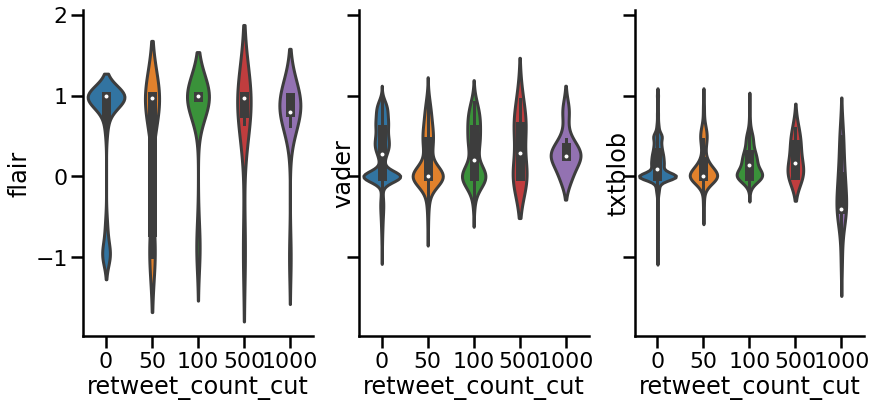

In [238]:
f, ax = plt.subplots(1, 3, figsize = (14, 6), sharey = True, sharex = True)
for idx, m in enumerate(models):  
    sns.violinplot(x = x + "_cut", y = m, data = df_tweets_2, ax = ax[idx])
# plt.savefig("sentim-by-{}.png".format(x))

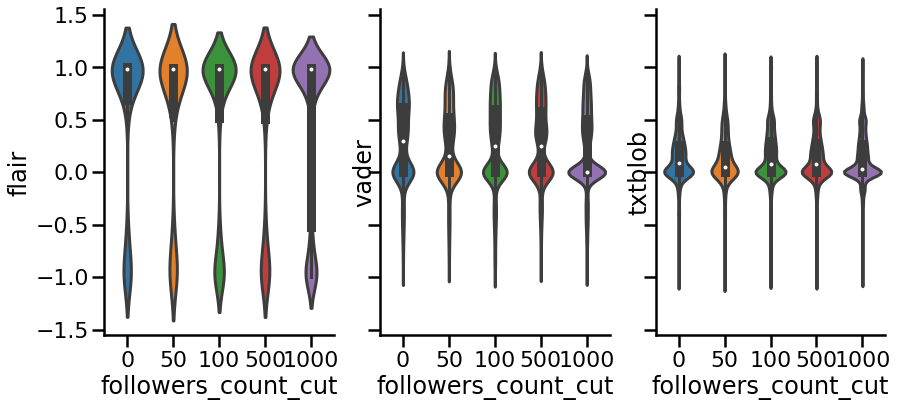

In [200]:
x = "followers_count"
bins = [0, 50, 100, 500, 1000, 2e7]
df_tweets_2[x + "_cut"] = pd.cut(df_tweets_2[x], bins = bins,  labels= bins[:-1]) 

f, ax = plt.subplots(1, 3, figsize = (14, 6), sharey = True, sharex = True)
for idx, m in enumerate(models):  
    sns.violinplot(x = x + "_cut", y = m, data = df_tweets_2, ax = ax[idx])
plt.savefig("sentim-by-{}.png".format(x))

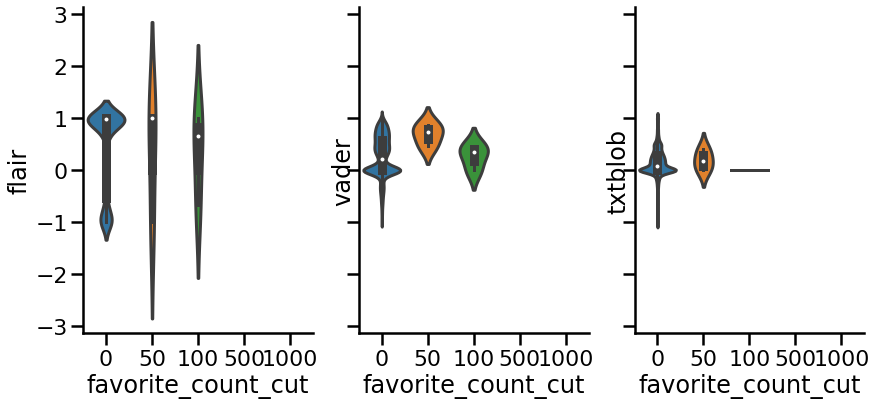

In [199]:
x = "favorite_count"
bins = [0, 50, 100, 500, 1000, 2e7]
df_tweets_2[x + "_cut"] = pd.cut(df_tweets_2[x], bins = bins,  labels= bins[:-1]) 

f, ax = plt.subplots(1, 3, figsize = (14, 6), sharey = True, sharex = True)
for idx, m in enumerate(models):  
    sns.violinplot(x = x + "_cut", y = m, data = df_tweets_2, ax = ax[idx])
plt.savefig("sentim-by-{}.png".format(x))

### Sentiment-across-time

In [242]:
from matplotlib.dates import DateFormatter

,txtblob
created_at,
2020-09-04 22:00:00,0.186997
2020-09-05 00:00:00,0.088374
2020-09-05 02:00:00,0.228973
2020-09-05 04:00:00,0.143933
2020-09-05 06:00:00,0.166951
...,...
2020-09-25 16:00:00,0.069899
2020-09-25 18:00:00,0.205689
2020-09-25 20:00:00,0.048400


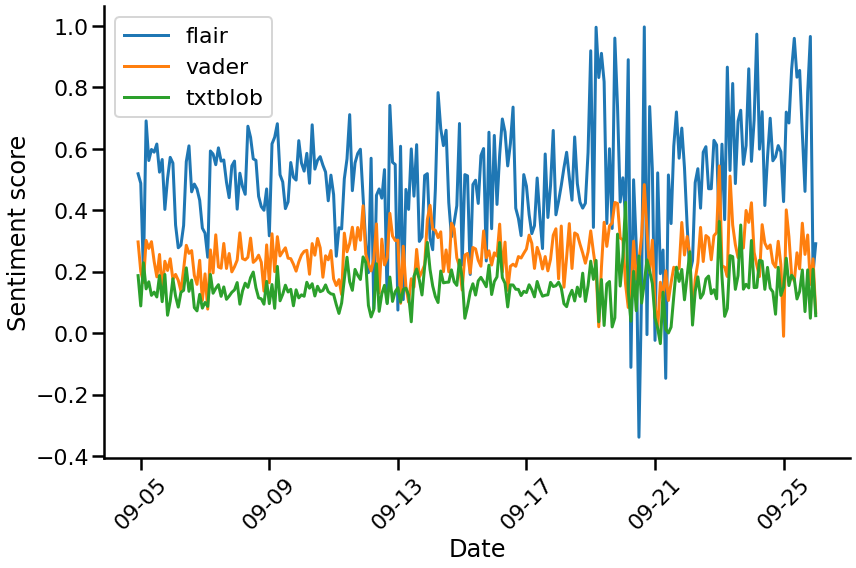

In [258]:
f, ax = plt.subplots(figsize =(12, 8))
for idx,m in enumerate(models):
    tmp =  df_tweets_2[["created_at", m]].set_index("created_at").resample('2H').mean().reset_index()
    ax = sns.lineplot(x = "created_at" , y = m, data = tmp, ci = False , label = m)

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment score')
# plt.legend(bbox_to_anchor=(.7, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig("sentiment-across-time.png")

### Term frequency

In [ ]:
from nltk.tokenize import word_tokenize
import re
import operator 
from collections import Counter
from nltk.corpus import stopwords
import string

In [ ]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [ ]:
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ["amp", "reality", "#machinelearning", "#technology",
                "#virtualreality", "#augmentedreality", "reality", "#iiot", "#artificialintelligence",
                 'virtual', 'augmented' ]


In [ ]:
neg_tweets = df_sentim[(df_sentim.value == "POSITIVE") ].tweet_id.values
count_terms = Counter()
count_hash = Counter()

for idx in df_tweets[df_tweets.id.isin(neg_tweets)].index[:]:
    text = get_status_text(df_tweets.iloc[idx])

    terms_hash = [term for term in preprocess(text) 
              if term not in stop and len(term) > 3 and term.startswith('#')]
    terms_only = [term for term in preprocess(text) 
              if term not in stop and len(term) > 3 and
              not term.startswith(('#', '@'))] 

    # Update the counter
    count_hash.update(terms_hash)
    count_terms.update(terms_only)

print(count_hash.most_common(10))
print(count_terms.most_common(10))

In [ ]:

path_image = r"U:\Data_Analysis\pak6\DS project\Huawei-VR-Glass.jpg"
mask = np.array(Image.open(path_image))

In [ ]:
x, y = np.ogrid[:300, :300]

# mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
# mask = 255 * mask.astype(int)

_input = count_terms
wc1 = WordCloud( mask = mask, contour_width=3, contour_color= 'steelblue',
                background_color ='white', max_font_size=50, 
                max_words=200, random_state=42, 
                min_font_size = 10).generate_from_frequencies(_input) 

_input = count_hash
wc2 = WordCloud( mask = np.flip(mask, axis = 1), contour_width=3, contour_color= 'steelblue',
                background_color ='white', max_font_size=50, 
                max_words=200, random_state=42, 
                min_font_size = 10).generate_from_frequencies(_input) 

# plot the WordCloud image                        
f, ax = plt.subplots(1, 2, figsize = (16, 16), facecolor = None) 
ax[0].imshow(wc1, interpolation='bilinear') 
ax[1].imshow(wc2, interpolation='bilinear') 
ax[0].axis("off") 
ax[1].axis("off") 
plt.tight_layout(pad = 0) 

### Popular videos on twitter

In [ ]:
def extract_video_links(extended_entities, ext = "mp4"):
    try:
        out_url = extended_entities["media"][0]["video_info"]["variants"][0]["url"]
        if ext in out_url:
            return out_url 
    except:
        return np.nan

In [ ]:
# extract video links
df_tweets.loc[:,"vid_link"] = df_tweets.extended_entities.apply(lambda x: extract_video_links(x))

In [ ]:
# removed duplicates and empty rows
df_sub = df_tweets.drop_duplicates(subset = ["vid_link"])
df_sub = df_sub.dropna(subset = ["vid_link"])
df_sub = df_sub.nlargest(10, "retweet_count")

In [ ]:
# detect possibly sensitive content
df_sub[df_sub.possibly_sensitive == 1]

In [ ]:
import requests

In [ ]:
# download all vidoes to the new folder
mydir = os.path.join(os.getcwd(),"vidoes_" + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(mydir)

for tweet_id in df_sub.id[:]:
    image_link = df_sub[df_sub["id"] == tweet_id]["vid_link"].values[0]
    print (tweet_id, image_link)
    
    image = requests.get(image_link)
    file_name = "{}.mp4".format(tweet_id)
    des_path = os.path.join(mydir, file_name)
    if 200 == image.status_code:
        with open(des_path, 'wb') as f:
            f.write(image.content)
    

In [ ]:
from moviepy.editor import *
from pathlib import Path

video_files = list(Path(mydir).glob("*.mp4"))

In [ ]:
# combine all videos and add tweet text
# use only first 10s. of eahc video
L = []

for vid in video_files[:]:
    print (vid)
    video = VideoFileClip(vid.as_posix(), audio=False)
    video = video.subclip(0, 7)
    video = video.resize(height = 360)
    tweet_text = get_status_text(df_tweets[df_tweets.id == int(vid.name.split(".")[0])]).values[0]
    txt_clip = TextClip(tweet_text, fontsize = 20, color='white', method = "caption").set_duration(3)
    
    txt_col = txt_clip.on_color( size = video.size,
                  color=(0,0,0), pos=(6,'center'), col_opacity=0.6)
    
    video = CompositeVideoClip([video, txt_col])
    
    L.append(video)
final_clip = concatenate_videoclips(L, method = "compose")
final_clip.to_videofile("combined.mp4" )

In [ ]:
video.ipython_display(height = 240)

In [ ]:
tweet_text